# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

* Based on best cutoff, may needed to re-do the phyloseq dataset partitioning (prior notebook)
* Using multiple 'heavy' BD windows for the DESeq2 analysis
  * 1 DESeq2 run per window
  * combining DESeq2 results
  * global adjustment of P-values

# Setting variables

In [2]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqFile = 'SIP-core'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

# Init

In [3]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [13]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [14]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


# Loading phyloseq

In [185]:
%%R -i physeqDir -i physeqFile 

F = file.path(physeqDir, physeqFile)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 147 taxa and 607 samples ]
sample_data() Sample Data:       [ 607 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 147 taxa by 7 taxonomic ranks ]


## MW-HR-SIP

In [206]:
%%R
# check on number of gradients

n.gradient = physeq %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Treatment, Land_Management, Replicate) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 26 


In [208]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, l2fc_threshold, Treatment, Land_Management, Day, Replicate, 
                  sparsity_threshold, density_min, density_max){
        
    # function for calculating log2 fold change p-values
    Treatment = c(Treatment %>% as.character)
    physeq.md = sample_data(physeq.obj)
    
    # filtering
    p.12C = prune_samples((! is.na(physeq.md$Density)) &
                          (physeq.md$Treatment == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Land_Management == Land_Management),
                           physeq.obj)
    p.13C = prune_samples((! is.na(physeq.md$Density)) & 
                      (physeq.md$Treatment == Treatment) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate)&
                      (physeq.md$Land_Management == Land_Management),
                      physeq.obj)
    physeq.m = merge_phyloseq(p.12C, p.13C) 
    physeq.md = sample_data(physeq.m)
    p.12C = p.13C = NULL
    
    # sparcity cutoff applied to all gradient fractions
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)   
    
    # applying 'heavy' window pruning
    physeq.m = prune_samples((physeq.md$Density >= density_min) &
                             (physeq.md$Density <= density_max),  physeq.m)
    
    # removing 0-abundance taxa
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > 0 * length(x), TRUE)
        
    # sparsity cutoff applied to just heavy fractions
    #physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])

    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
        
    # setting pruning info
    d$density_min = density_min
    d$density_max = density_max
    d$sparsity_threshold = sparsity_threshold
    return(d)
}
                                                         

## Making a table of variable params for the multiple DESeq2 runs

In [15]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq %>% sample_data %>% 
    filter(! is.na(Density),
           Treatment != '12C') %>%
    select(Treatment, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Treatment, Day, Replicate, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)

[1] 16
  Treatment Day Replicate Land_Management
1       13C   3         4             NTH
2       13C   3         4             PTH
3       13C   7         4             NTH
4       13C   7         4             PTH
5       13C  14         4             NTH


In [16]:
%%R
# checking that there's only one microcosm replicate per treatment
sdm %>%
    group_by(Treatment, Day, Land_Management) %>%
    summarize(n_reps=n()) #%>%
   # group_by(n_reps) %>%
    #summarize(n_treatments = n())

Source: local data frame [16 x 4]
Groups: Treatment, Day [?]

   Treatment   Day Land_Management n_reps
      (fctr) (int)          (fctr)  (int)
1        13C     3             NTH      1
2        13C     3             PTH      1
3        13C     7             NTH      1
4        13C     7             PTH      1
5        13C    14             NTH      1
6        13C    14             PTH      1
7        13C    30             NTH      1
8        13C    30             PTH      1
9        13X     1             NTH      1
10       13X     1             PTH      1
11       13X     3             NTH      1
12       13X     3             PTH      1
13       13X     7             NTH      1
14       13X     7             PTH      1
15       13X    14             NTH      1
16       13X    14             PTH      1


In [17]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Treatment, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                   BD_windows = BD_windows,
                   sparsity_threshold = seq(0.05,0.5,0.05)) %>%
    separate(Var1, c('Treatment', 'Day', 'Replicate', 'Land_Management'), sep='___') %>%
    separate(BD_windows, c('density_min', 'density_max'), sep='-')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(n=3) %>% print
print('-------------------')
sdms %>% tail(n=3) %>% print

Number of pairwise combinations of variables: 480 

  Treatment Day Replicate Land_Management density_min density_max
1       13C   3         4             NTH        1.70        1.73
2       13C   3         4             PTH        1.70        1.73
3       13C   7         4             NTH        1.70        1.73
  sparsity_threshold
1               0.05
2               0.05
3               0.05
[1] "-------------------"
    Treatment Day Replicate Land_Management density_min density_max
478       13X   7         4             PTH        1.74        1.77
479       13X  14         4             NTH        1.74        1.77
480       13X  14         4             PTH        1.74        1.77
    sparsity_threshold
478                0.5
479                0.5
480                0.5


## DESeq2 runs

In [18]:
%%R 
registerDoParallel(nprocs)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = TRUE, 
                physeq.obj = physeq,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

df.l2fc %>% head(n=3) %>% as.data.frame

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940    -0.03800619 0.6963398
2       13C   3         4             NTH OTU.4163     0.29055250 0.4758928
3       13C   3         4             NTH OTU.5493    -0.24775395 0.8663980
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


In [19]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
saveRDS(df.l2fc, outFile)

In [15]:
%pushnote 1_sparsity_cutoff DESeq2 complete

ERROR: Line magic function `%pushnote` not found.


## Summing number of rejected hypotheses per DESeq2 run

In [31]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
df.l2fc = readRDS(inFile)
df.l2fc$Day = reorder(df.l2fc$Day, df.l2fc$Day %>% as.numeric)

# status
df.l2fc %>% head(n=3) %>% as.data.frame

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940    -0.03800619 0.6963398
2       13C   3         4             NTH OTU.4163     0.29055250 0.4758928
3       13C   3         4             NTH OTU.5493    -0.24775395 0.8663980
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


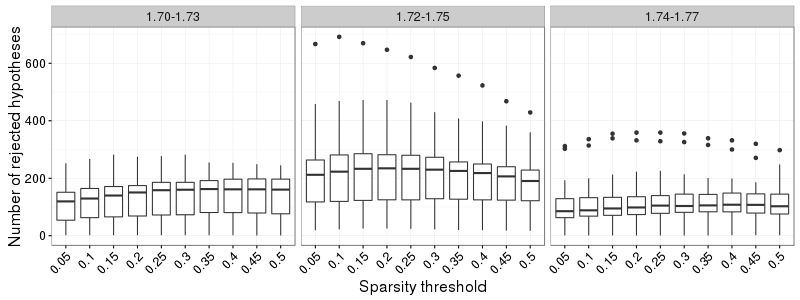

In [32]:
%%R -w 800 -h 300
df.l2fc.s = df.l2fc %>%
    unite(density_window, density_min, density_max, sep='-', remove=FALSE) %>%
    mutate(rej_hypo = padj < padj_cutoff) %>%
    group_by(density_window, sparsity_threshold, Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_rej_hypo = sum(rej_hypo, na.rm=TRUE)) 


ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_rej_hypo)) +
    geom_boxplot() +
    facet_wrap(~ density_window) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

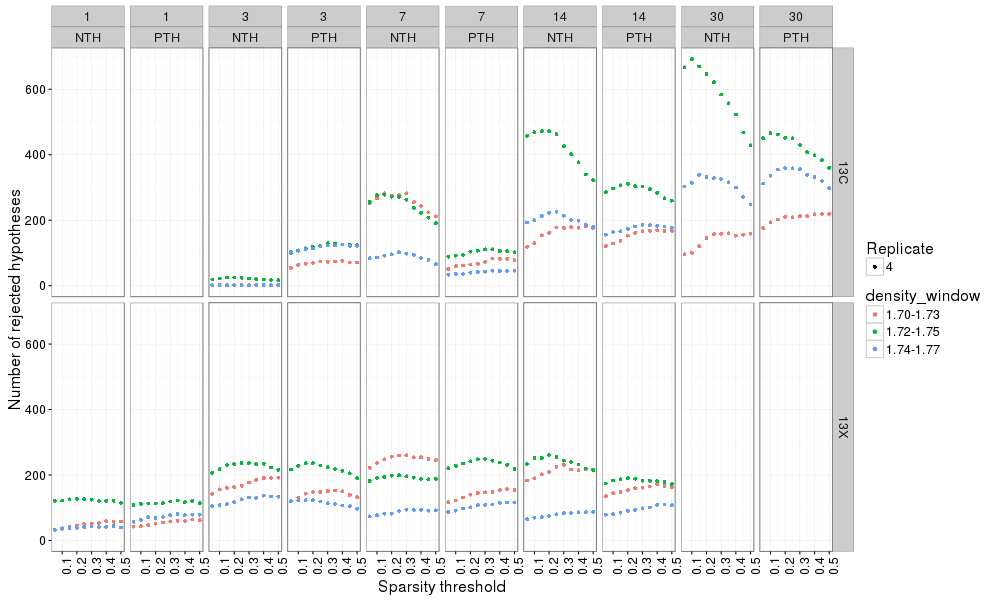

In [36]:
%%R -w 1000 -h 600
ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point() +
    facet_grid(Treatment ~ Day + Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, hjust=1)
    )

In [37]:
%%R
ggsave('data/figs/sparsitywindows.jpg', width = 12, height = 6)

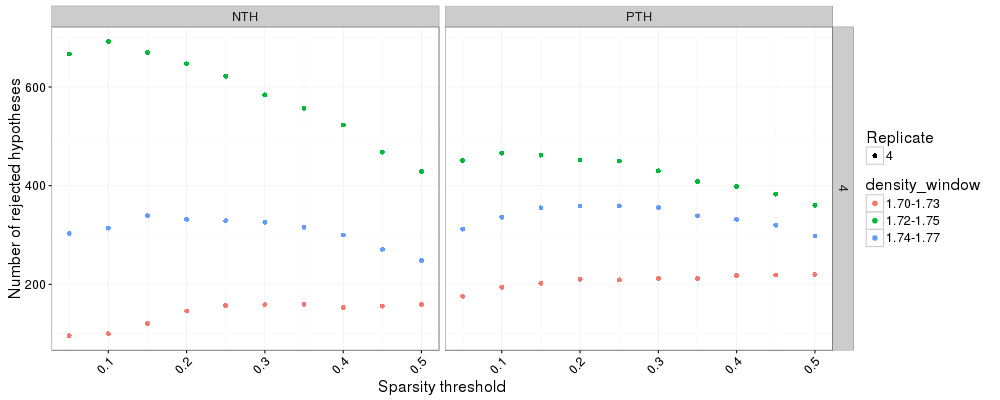

In [19]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 30, Treatment == '13C')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )

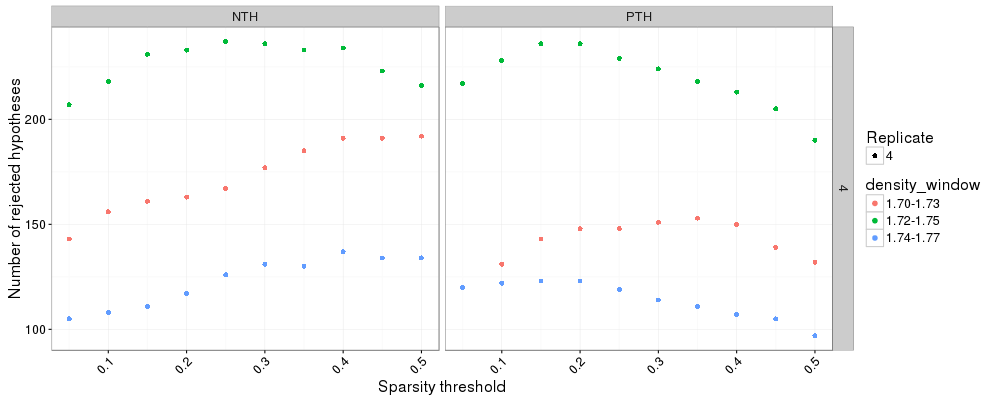

In [20]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 3, Treatment == '13X')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )

### Number of taxa for each  sparsity cutoff

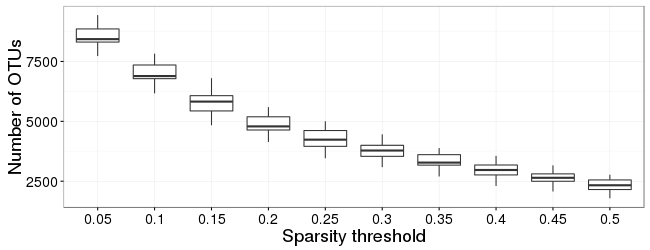

In [21]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.s = df.l2fc %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold) %>%
    summarize(n_OTUs = OTU %>% unique %>% length) 

ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_OTUs)) +
    geom_boxplot() +
    labs(x='Sparsity threshold', y='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        ) 

## For each treatment, selecting sparsity cutoff with most rejHypo

In [22]:
%%R
# selecting sparsity cutoffs
cat('Pre-filter:', df.l2fc %>% nrow, '\n')
df.l2fc.f = df.l2fc %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, density_min, density_max) %>% 
    mutate(n_rej_hypo = sum(padj < padj_cutoff, na.rm=TRUE)) %>%  # nRejHypos for each treat-spar-window combo
    group_by(Treatment, Day, Replicate, Land_Management, density_min, density_max) %>%
    filter(n_rej_hypo == max(n_rej_hypo)) %>%   # just best sparsity for treat-window combo
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, density_min, density_max, OTU) 
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

df.l2fc.f %>% head(n=3) %>% as.data.frame

Pre-filter: 2108082 
Post-filter: 191853 
  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940    -0.03800619 0.6963398
2       13C   3         4             NTH OTU.4163     0.29055250 0.4758928
3       13C   3         4             NTH OTU.5493    -0.24775395 0.8663980
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold n_rej_hypo
1  <NA>  <NA>        1.70        1.73               0.05          2
2  <NA>  <NA>        1.70        1.73               0.05          2
3  <NA>  <NA>        1.70        1.73               0.05          2


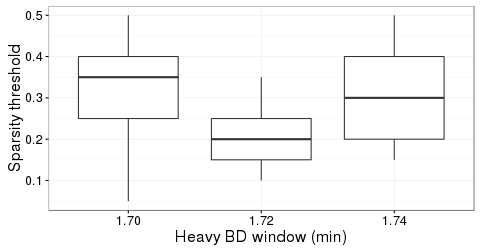

In [23]:
%%R -h 250
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Global correction of p-values

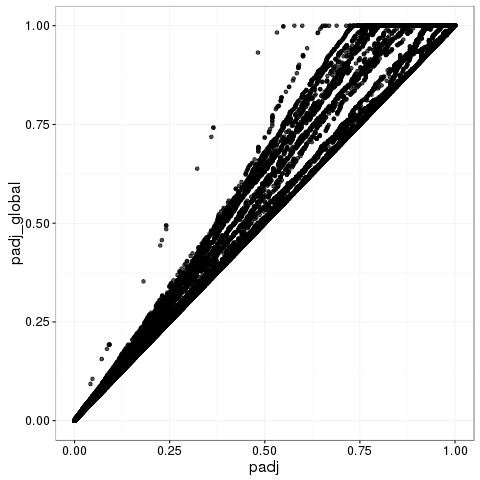

In [24]:
%%R
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    mutate(padj_global = p.adjust(p, method='BH'),
           padj_global = ifelse(padj_global < padj, padj, padj_global)) %>%
    ungroup() 

p1 = ggplot(df.l2fc.f, aes(padj, padj_global)) +
    geom_point(alpha=0.7) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

df.l2fc.f = df.l2fc.f %>%
    mutate(padj = padj_global) %>%
    select(-padj_global)

p1

## Selecting max l2fc for each treatment-OTU

In [25]:
%%R
cat('Pre-filter:', df.l2fc.f %>% nrow, '\n')
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, OTU) %>%
    filter(log2FoldChange == max(log2FoldChange, na.rm=TRUE)) %>%
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, OTU) %>%
    select(-n_rej_hypo)
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

Pre-filter: 191853 
Post-filter: 80865 


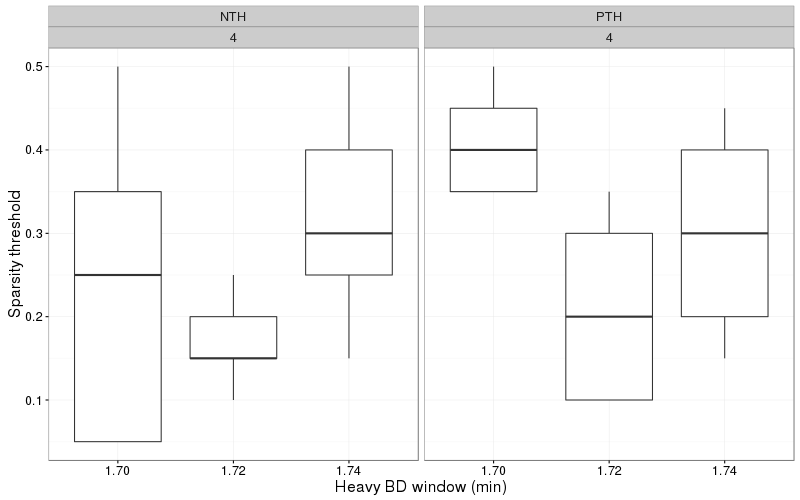

In [26]:
%%R -h 500 -w 800
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16) 
    ) + facet_wrap(Land_Management ~ Replicate)

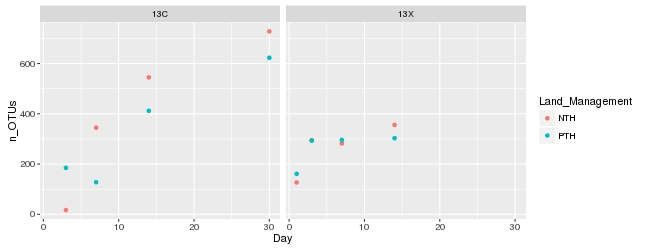

In [27]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.f.s = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>% filter(padj <=0.10) %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_OTUs = n()) 

ggplot(df.l2fc.f.s, aes(Day, n_OTUs, color=Land_Management, group=Replicate)) +
    geom_point()  + facet_wrap(~Treatment)
    #geom_line()

In [28]:
%%R
# checking that there's only 1 OTU value per treatment
df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, OTU) %>%
    summarize(n = n()) %>%
    ungroup %>%
    filter(n > 1) %>% as.data.frame

[1] Treatment          Day                Replicate          Land_Management   
[5] sparsity_threshold OTU                n                 
<0 rows> (or 0-length row.names)


In [29]:
%%R -i workDir
# Writing out l2fc table

outFile = file.path(workDir, 'l2fc_sparse-maxRejH.txt')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

# Plotting the results

## l2fc plot

In [39]:
%%R
df.l2fc.f = read.table('/home/chantal/Chazy/Chazy_SIP/data/l2fc_sparse-maxRejH.txt', sep = '\t', header = TRUE)
df.l2fc.f$Substrate = df.l2fc.f$Treatment
df.l2fc.f$ls = as.character(paste(df.l2fc.f$Treatment, df.l2fc.f$Land_Management, sep = "-"))

In [40]:
%%R
resp_num = filter(df.l2fc.f, padj <=0.10)
print(length(resp_num$OTU))
print(length(unique(resp_num$OTU)))

[1] 5096
[1] 1913


In [41]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [4 x 2]

       ls  resp
    (chr) (int)
1 13C-NTH  1062
2 13C-PTH   935
3 13X-NTH   582
4 13X-PTH   604


In [42]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls, Day) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [16 x 3]
Groups: ls [?]

        ls   Day  resp
     (chr) (int) (int)
1  13C-NTH     3    17
2  13C-NTH     7   345
3  13C-NTH    14   545
4  13C-NTH    30   728
5  13C-PTH     3   185
6  13C-PTH     7   128
7  13C-PTH    14   412
8  13C-PTH    30   623
9  13X-NTH     1   127
10 13X-NTH     3   295
11 13X-NTH     7   282
12 13X-NTH    14   356
13 13X-PTH     1   161
14 13X-PTH     3   293
15 13X-PTH     7   296
16 13X-PTH    14   303


In [43]:
%%R
N.X = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10)
P.X = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10)
N.C = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10)
P.C = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10)

In [44]:
%%R
print(length(intersect(N.X$OTU, P.X$OTU)))
print(length(intersect(N.X$OTU, N.C$OTU)))
print(length(intersect(N.X$OTU, P.C$OTU)))
print(length(intersect(P.X$OTU, N.C$OTU)))
print(length(intersect(P.X$OTU, P.C$OTU)))
print(length(intersect(N.C$OTU, P.C$OTU)))

[1] 352
[1] 263
[1] 224
[1] 269
[1] 281
[1] 440


In [45]:
%%R ## OTUs intersecting across entire timepoints
length(Reduce(intersect, list(N.X$OTU, P.X$OTU, N.C$OTU, P.C$OTU)))

NULL


In [46]:
%%R
#Looking at non-overlap communities b/t NT Xyl, PT Xyl and NT Cell, PT Cell
N.X.no = filter(N.X, !(OTU %in% intersect(N.X$OTU, P.X$OTU)))
P.X.no = filter(P.X, !(OTU %in% intersect(N.X$OTU, P.X$OTU)))

N.C.no = filter(N.C, !(OTU %in% intersect(N.C$OTU, P.C$OTU)))
P.C.no = filter(P.C, !(OTU %in% intersect(N.C$OTU, P.C$OTU)))

In [47]:
%%R
#NTH-Xylose specific OTUs 
uniqueresp = N.X.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   179 0.77826087
2     2    42 0.18260870
3     3     9 0.03913043


In [48]:
%%R
#PTH-Xylose specific OTUs 
uniqueresp = P.X.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [4 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   188 0.74603175
2     2    43 0.17063492
3     3    18 0.07142857
4     4     3 0.01190476


In [49]:
%%R
#NTH-Cellulose specific OTUs 
uniqueresp = N.C.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   460 0.73954984
2     2   125 0.20096463
3     3    37 0.05948553


In [50]:
%%R
#PTH-Cellulose specific OTUs 
uniqueresp = P.C.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num  percentage
  (int) (int)       (dbl)
1     1   377 0.761616162
2     2   115 0.232323232
3     3     3 0.006060606


In [51]:
%%R
N.X.D1 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 1)
P.X.D1 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 1)

N.X.D3 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 3)
P.X.D3 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 3)

N.X.D7 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 7)
P.X.D7 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 7)

N.X.D14 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 14)
P.X.D14 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 14)

In [52]:
%%R
print(length(intersect(N.X.D1$OTU, P.X.D1$OTU)))
print(length(intersect(N.X.D3$OTU, P.X.D3$OTU)))
print(length(intersect(N.X.D7$OTU, P.X.D7$OTU)))
print(length(intersect(N.X.D14$OTU, P.X.D14$OTU)))

[1] 65
[1] 134
[1] 145
[1] 177


In [53]:
%%R
overlap = c(65, 134, 147, 177)
Day = as.factor(c(1,3,7,14))
xyl.comm.OTUs = data.frame(overlap, Day)

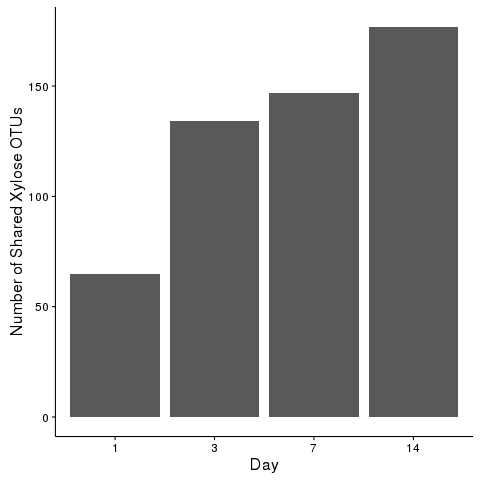

In [54]:
%%R
overlap.xyl = ggplot(xyl.comm.OTUs, aes(x = Day, y = overlap)) + geom_bar(stat= 'identity') + 
        ylab('Number of Shared Xylose OTUs') + theme(text = element_text(size=16))
overlap.xyl

In [55]:
%%R
N.C.D3 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 3)
P.C.D3 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 3)

N.C.D7 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 7)
P.C.D7 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 7)

N.C.D14 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 14)
P.C.D14 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 14)

N.C.D30 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 30)
P.C.D30 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 30)

In [56]:
%%R
print(length(intersect(N.C.D3$OTU, P.C.D3$OTU)))
print(length(intersect(N.C.D7$OTU, P.C.D7$OTU)))
print(length(intersect(N.C.D14$OTU, P.C.D14$OTU)))
print(length(intersect(N.C.D30$OTU, P.C.D30$OTU)))

[1] 13
[1] 64
[1] 243
[1] 216


In [57]:
%%R
overlap = c(13, 64, 243, 216)
Day = as.factor(c(3,7,14,30))
cell.comm.OTUs = data.frame(overlap, Day)

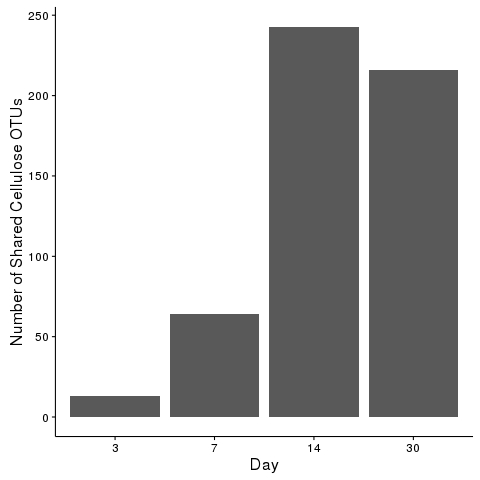

In [58]:
%%R
overlap.cell = ggplot(cell.comm.OTUs, aes(x = Day, y = overlap)) + geom_bar(stat= 'identity') + 
        ylab('Number of Shared Cellulose OTUs') + theme(text = element_text(size=16))
overlap.cell

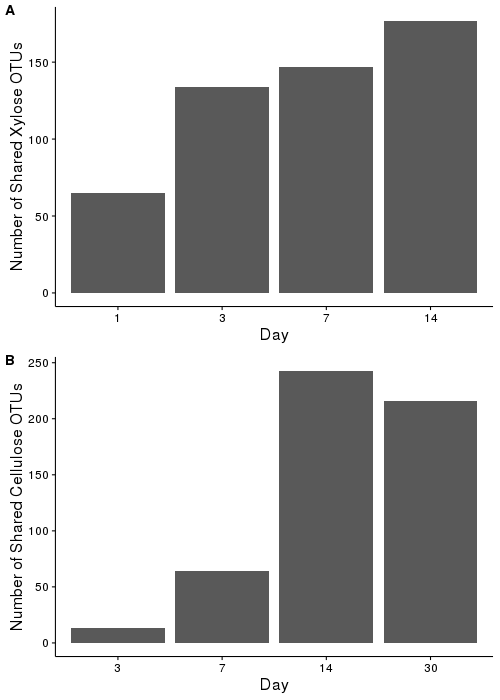

In [59]:
%%R -w 500 -h 700
library(cowplot)


plot_grid(overlap.xyl, overlap.cell, nrow = 2, align = 'v', rel_heights = c(5, 5), labels = c("A", "B"))


In [60]:
%%R
resp.time.treat = df.l2fc.f %>% filter(padj <=0.10) %>% group_by(Treatment, Rank2, Day, Land_Management)%>%
                    summarise(counts = n())

filter(resp.time.treat, Treatment == '13X') %>% ungroup() %>% arrange(Rank2) %>%as.data.frame

   Treatment                     Rank2 Day Land_Management counts
1        13X           __Acidobacteria   1             PTH      1
2        13X           __Acidobacteria   3             PTH      1
3        13X           __Acidobacteria   7             PTH      2
4        13X           __Acidobacteria  14             NTH      3
5        13X          __Actinobacteria   1             NTH     61
6        13X          __Actinobacteria   1             PTH     59
7        13X          __Actinobacteria   3             NTH     85
8        13X          __Actinobacteria   3             PTH     68
9        13X          __Actinobacteria   7             NTH     57
10       13X          __Actinobacteria   7             PTH     59
11       13X          __Actinobacteria  14             NTH     60
12       13X          __Actinobacteria  14             PTH     79
13       13X         __Armatimonadetes   7             PTH      1
14       13X           __Bacteroidetes   1             NTH      9
15       1

In [61]:
%%R
resp.time.treat = df.l2fc.f %>% filter(padj <=0.10, Rank2 == "Actinobacteria") %>% group_by(Treatment, Rank2, Day, Land_Management)%>%
                    summarise(counts = n())

filter(resp.time.treat, Treatment == '13C') %>% ungroup() %>% arrange(Rank2) %>%as.data.frame

[1] Treatment       Rank2           Day             Land_Management
[5] counts         
<0 rows> (or 0-length row.names)


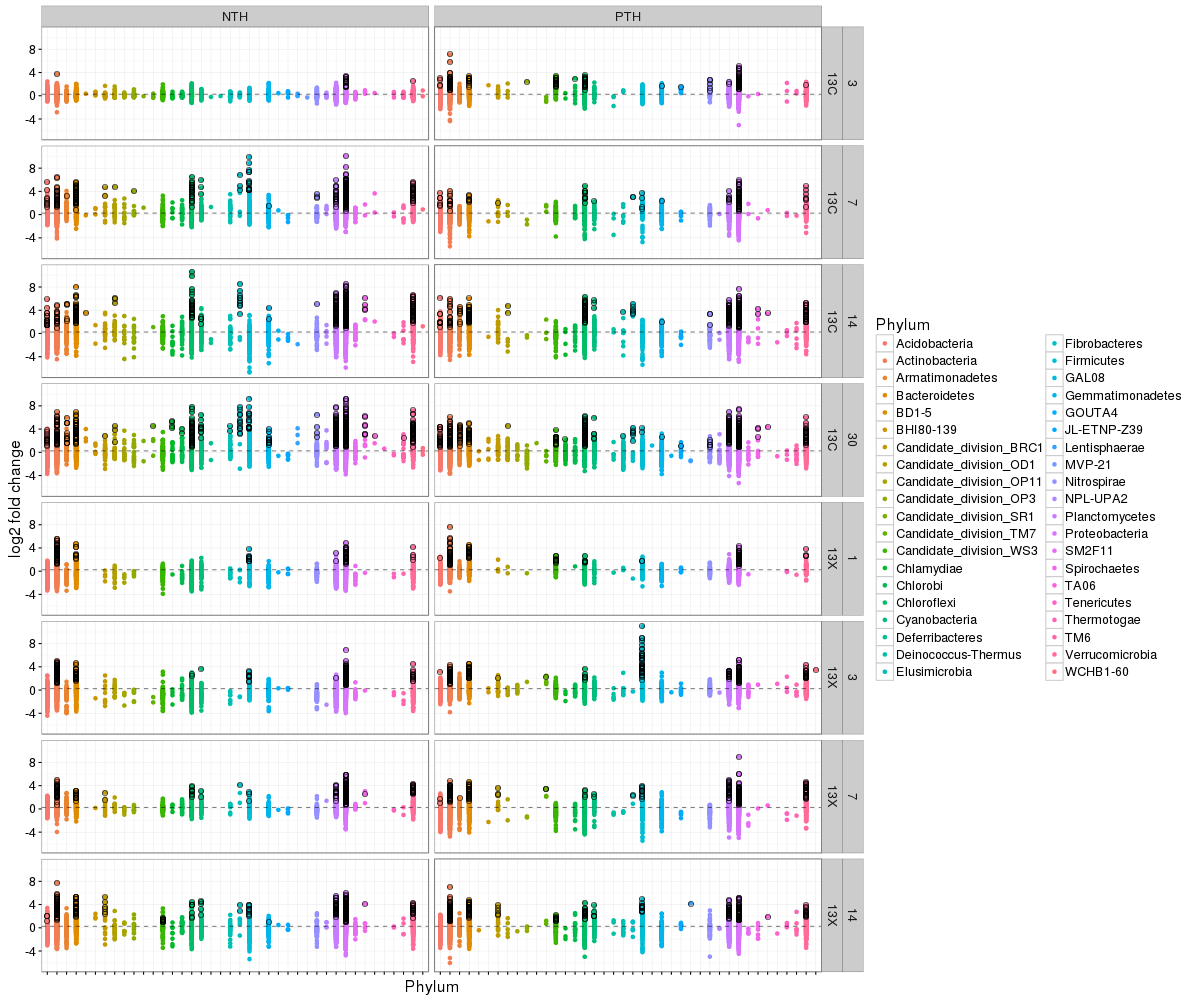

In [62]:
%%R -w 1200 -h 1000

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

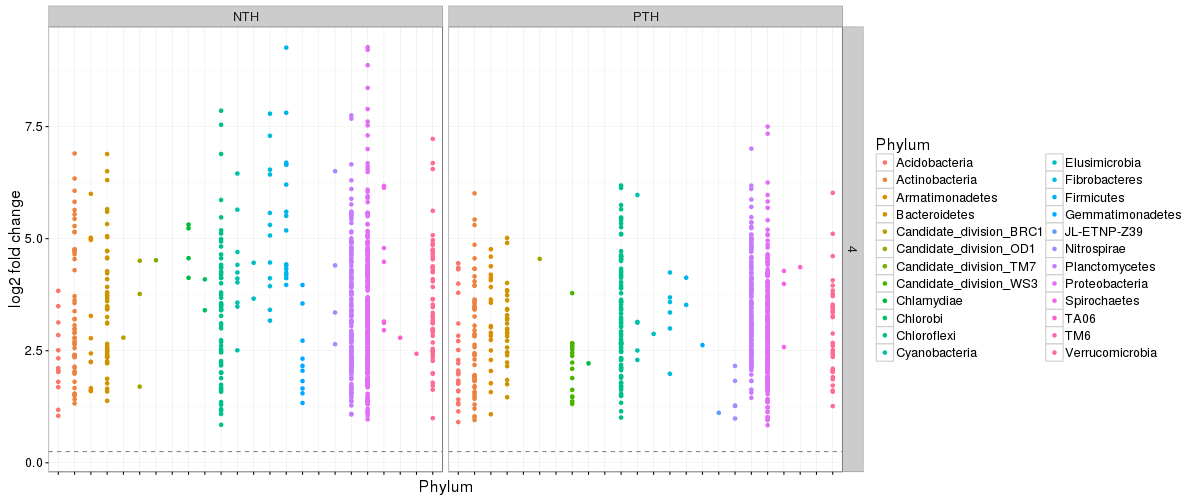

In [63]:
%%R -w 1200 -h 500
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13C', Day == 30) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

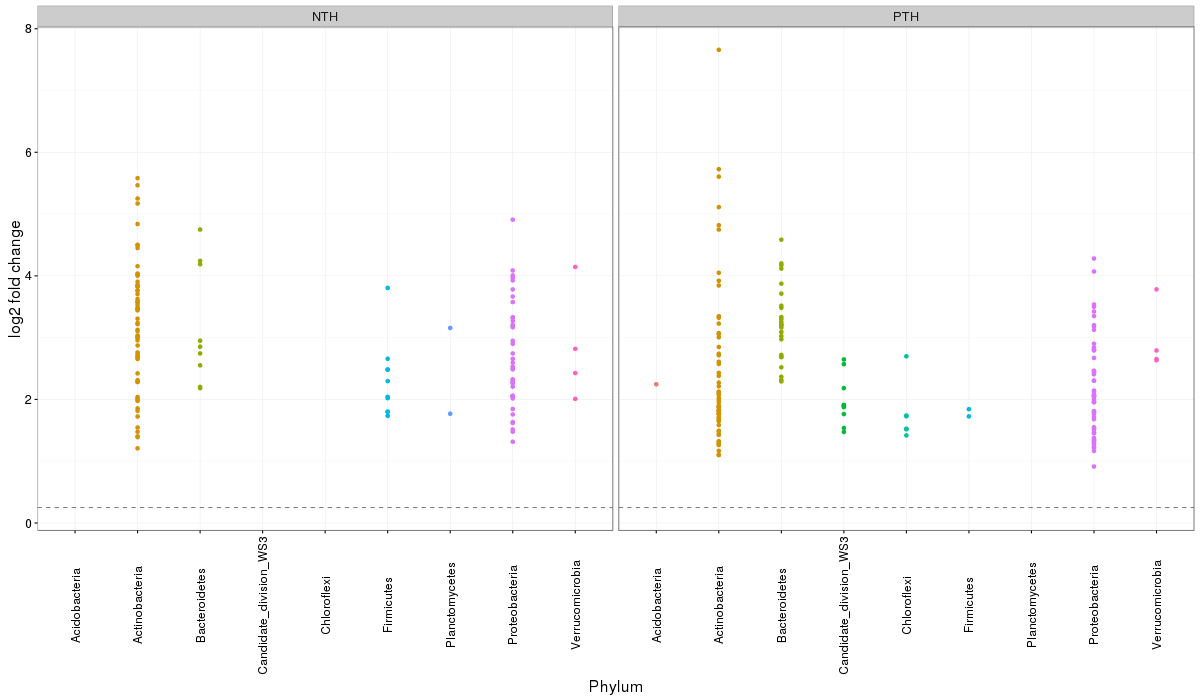

In [64]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 1) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid( .~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

In [65]:
%%R
df.l2fc.f.sig %>% filter(Land_Management == 'NTH', Rank2 == 'Planctomycetes')

  Treatment Day Replicate Land_Management     OTU log2FoldChange            p
1       13X   1         4             NTH OTU.616       3.156954 9.652963e-05
2       13X   1         4             NTH  OTU.99       1.769924 2.056589e-03
         padj    Rank1          Rank2              Rank3                  Rank4
1 0.006603616 Bacteria Planctomycetes        __vadinHA49 __uncultured_bacterium
2 0.090751649 Bacteria Planctomycetes __Planctomycetacia     __Planctomycetales
                Rank5          Rank6                      Rank7 Rank8
1                <NA>           <NA>                       <NA>  <NA>
2 __Planctomycetaceae __Pir4_lineage __uncultured_planctomycete  <NA>
  density_min density_max sparsity_threshold Substrate      ls
1        1.72        1.75                0.2       13X 13X-NTH
2        1.70        1.73                0.4       13X 13X-NTH


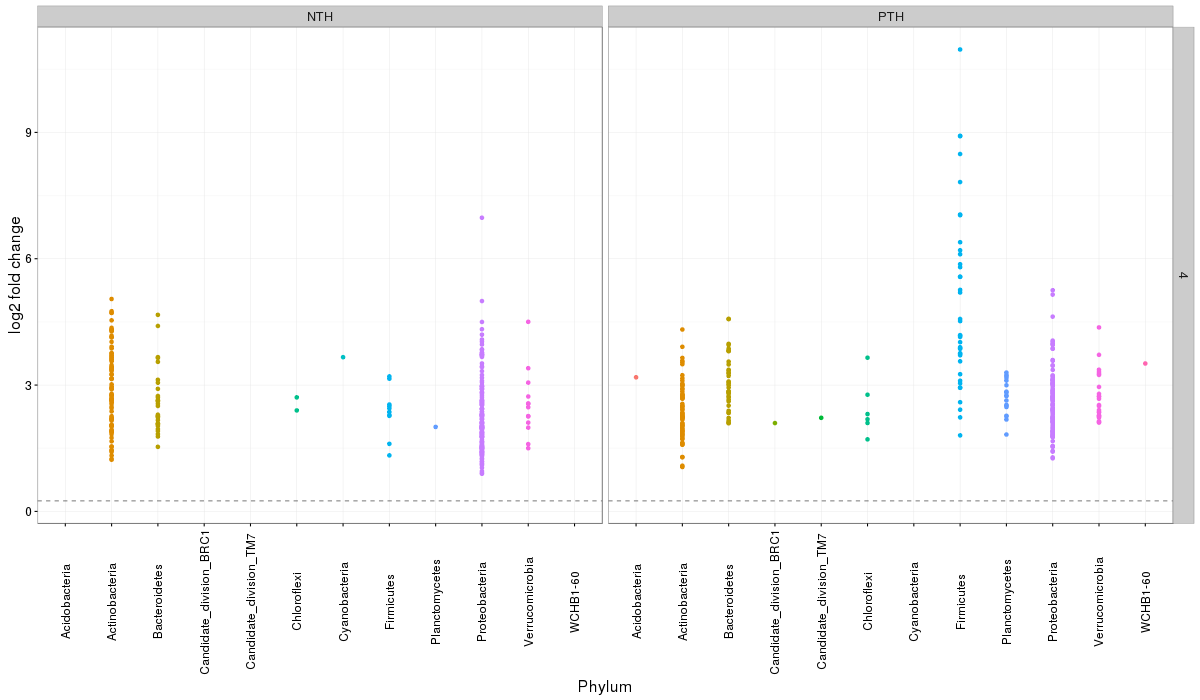

In [66]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 3) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

In [67]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=12, height=9)

### Example figure

In [68]:
%%R
test = df.l2fc.f.f

test$num = as.numeric(as.factor((test$Rank2)))

head(test) %>% as.data.frame


Error in withVisible({ : object 'df.l2fc.f.f' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'df.l2fc.f.f' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 96 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 1 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


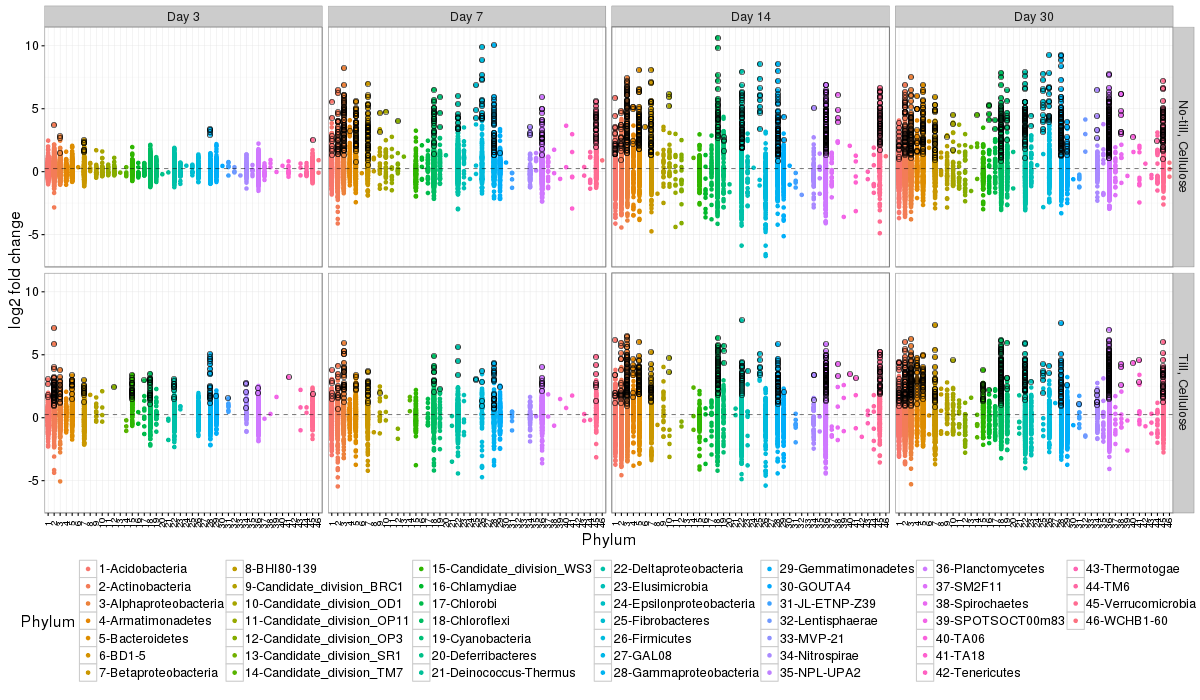

In [129]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13C') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.Prots = filter(df.l2fc.f.f, Rank2 == 'Proteobacteria')
df.Prots$Group = df.Prots$Rank3
df.nonProts = filter(df.l2fc.f.f, Rank2 != 'Proteobacteria')
df.nonProts$Group = df.nonProts$Rank2

df.filt = rbind(df.Prots, df.nonProts)

df.filt = df.filt %>%
    mutate(Group = gsub('^__', '', Group))%>%
    mutate(Group = Group %>% as.character)


#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.filt %>%
    filter(padj <= padj_cutoff) 

df.l2fc.f.f.sig$num = as.numeric(as.factor((df.l2fc.f.f.sig$Group)))
df.l2fc.f.f.sig$num_Group = paste(df.l2fc.f.f.sig$num, df.l2fc.f.f.sig$Group, sep = '-')
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

df.filt$num = as.numeric(as.factor((df.filt$Group)))
df.filt$num_Group = paste(df.filt$num, df.filt$Group, sep = '-')

df.filt = arrange(df.filt, Group)


names = c('13C-NTH' = "No-till, Cellulose",
          '13C-PTH' = "Till, Cellulose",
          '1' = "Day 1",
          '3' = "Day 3",
          '7' = "Day 7",
          '14' = "Day 14",
          '30' = "Day 30"
                    )



p.l2fc.x = ggplot(df.filt, aes(as.character(Group), color=Group)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day, labeller = as_labeller(names)) +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, size=9)) + #+
    scale_color_discrete(name = 'Phylum', labels = (unique(as.character(df.filt$num_Group)))) +
    scale_x_discrete(labels= unique((df.filt$num))) + theme(legend.position="bottom") +
    guides(col = guide_legend(nrow = 7))

p.l2fc.x

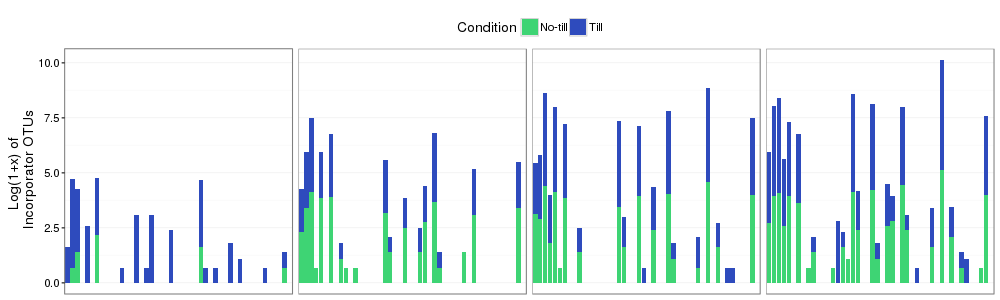

In [130]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.filt %>% group_by(Day,Group, ls) %>% summarise(resp = sum(padj <=0.10), 
                                                                         log1presp = log1p(resp))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Group, y = log1presp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') + 
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd"), labels = c('No-till', 'Till')) + theme(text = element_text(size = 14), axis.title.x = element_blank()) +
        ylab('Log(1+x) of \n Incorporator OTUs') +  scale_x_discrete(breaks=NULL)+  
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) + theme(legend.position="top") 
p.test

In [131]:
%%R -w 1500 -h 300
#Normalizing by every phyla, every day

hist.cell = df.l2fc.f.f %>% group_by(Day,Rank2) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

In [132]:
%%R
day = 30

hist.cell3 %>% filter(realresp >0.6, Day == day) %>% ungroup %>% arrange(Day, ls) %>% as.data.frame

   Day      ls                   Rank2  realresp
1   30 13C-NTH           Bacteroidetes 0.6410256
2   30 13C-NTH Candidate_division_BRC1 1.0000000
3   30 13C-NTH  Candidate_division_OD1 0.7500000
4   30 13C-NTH  Candidate_division_TM7 1.0000000
5   30 13C-NTH              Chlamydiae 0.8000000
6   30 13C-NTH                Chlorobi 1.0000000
7   30 13C-NTH           Cyanobacteria 0.6666667
8   30 13C-NTH           Elusimicrobia 0.6666667
9   30 13C-NTH           Fibrobacteres 0.6666667
10  30 13C-NTH              Firmicutes 0.8888889
11  30 13C-NTH        Gemmatimonadetes 0.9090909
12  30 13C-NTH            Spirochaetes 0.7000000
13  30 13C-NTH                     TM6 1.0000000
14  30 13C-NTH         Verrucomicrobia 0.6067416
15  30 13C-PTH           Acidobacteria 0.6410256
16  30 13C-PTH         Armatimonadetes 0.6250000
17  30 13C-PTH  Candidate_division_WS3 1.0000000
18  30 13C-PTH             JL-ETNP-Z39 1.0000000


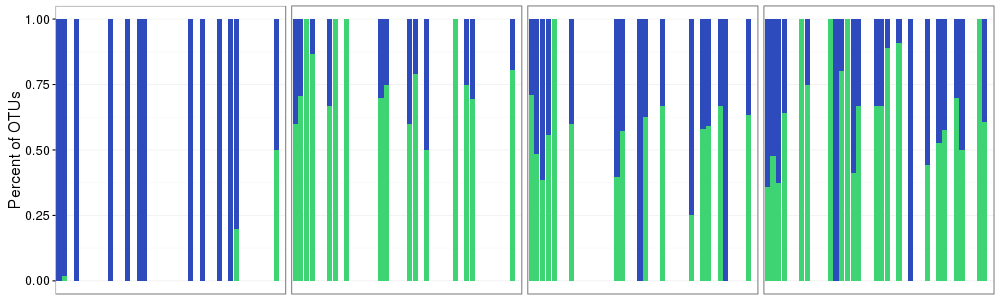

In [133]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [134]:
%%R -w 1500 -h 300
#Normalizing by every day

hist.cell = df.l2fc.f.f %>% group_by(Day) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

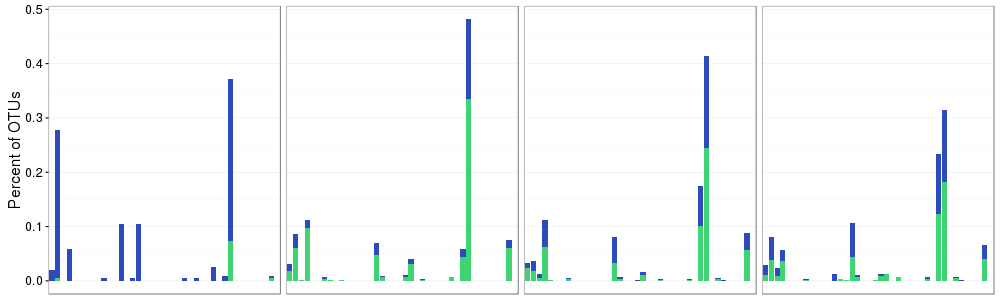

In [135]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

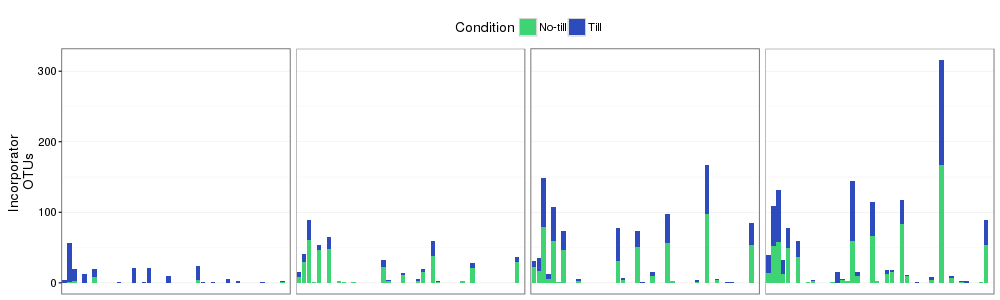

In [136]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.filt %>% group_by(Day, Group, ls) %>% summarise(resp = sum(padj <=0.10))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Group, y = resp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') + 
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd"), labels = c('No-till', 'Till')) + theme(text = element_text(size = 14), axis.title.x = element_blank()) +
        ylab('Incorporator \nOTUs') +  scale_x_discrete(breaks=NULL)+  
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) + theme(legend.position="top") 

p.test
p.test

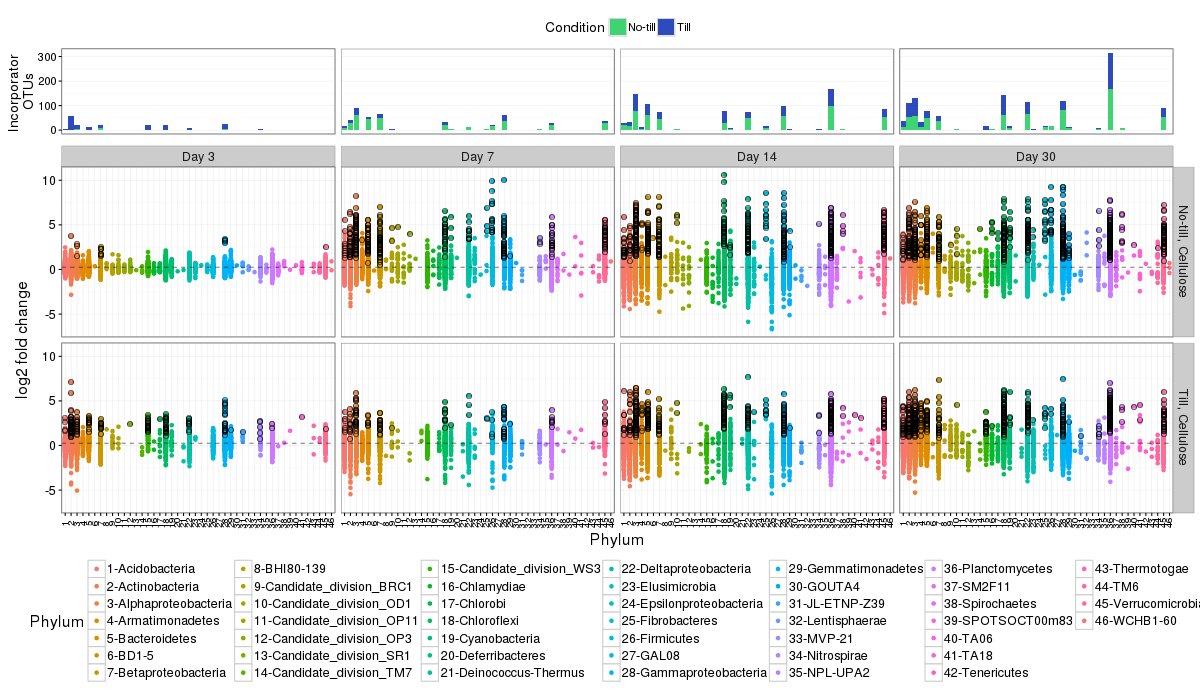

In [142]:
%%R -w 1200 -h 700
library(cowplot)


p = plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 10))
p

In [143]:
%%R
ggsave('data/figs/Cell_LFC.jpg', width = 18, height = 14)

In [108]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylumX.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=4)

outFile = 'l2fc_sparCutMax_byPhylumX2.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=16, height=8)

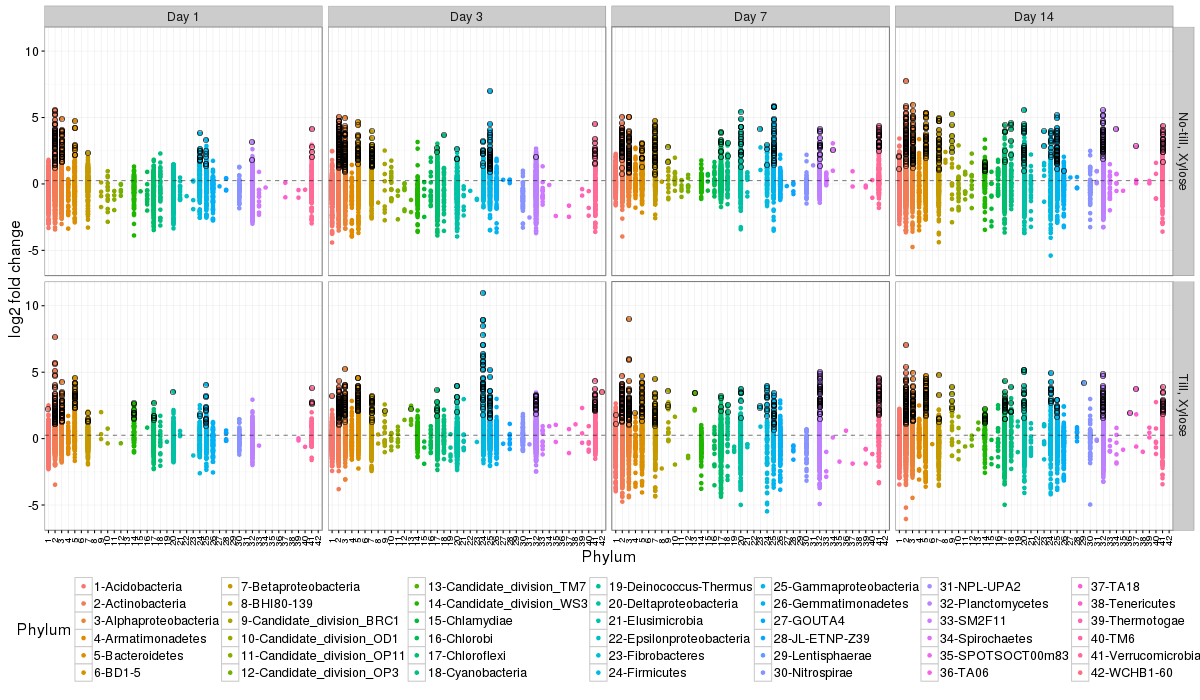

In [144]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.Prots = filter(df.l2fc.f.f, Rank2 == 'Proteobacteria')
df.Prots$Group = df.Prots$Rank3
df.nonProts = filter(df.l2fc.f.f, Rank2 != 'Proteobacteria')
df.nonProts$Group = df.nonProts$Rank2

df.filt = rbind(df.Prots, df.nonProts)

df.filt = df.filt %>%
    mutate(Group = gsub('^__', '', Group))%>%
    mutate(Group = Group %>% as.character)


#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.filt %>%
    filter(padj <= padj_cutoff) 

df.l2fc.f.f.sig$num = as.numeric(as.factor((df.l2fc.f.f.sig$Group)))
df.l2fc.f.f.sig$num_Group = paste(df.l2fc.f.f.sig$num, df.l2fc.f.f.sig$Group, sep = '-')
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

df.filt$num = as.numeric(as.factor((df.filt$Group)))
df.filt$num_Group = paste(df.filt$num, df.filt$Group, sep = '-')

df.filt = arrange(df.filt, Group)


names = c('13X-NTH' = "No-till, Xylose",
          '13X-PTH' = "Till, Xylose",
          '1' = "Day 1",
          '3' = "Day 3",
          '7' = "Day 7",
          '14' = "Day 14",
          '30' = "Day 30"
                    )



p.l2fc.x = ggplot(df.filt, aes(as.character(Group), color=Group)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day, labeller = as_labeller(names)) +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, size=9)) + #+
    scale_color_discrete(name = 'Phylum', labels = (unique(as.character(df.filt$num_Group)))) +
    scale_x_discrete(labels= unique((df.filt$num))) + theme(legend.position="bottom") +
    guides(col = guide_legend(nrow = 6))

p.l2fc.x

In [145]:
%%R
test = df.l2fc.f.f.sig %>% group_by(Rank2, Day) %>% summarise(counts = unique(n()))

test  %>% as.data.frame

                     Rank2 Day counts
1            Acidobacteria   1      1
2            Acidobacteria   3      1
3            Acidobacteria   7      2
4            Acidobacteria  14      3
5           Actinobacteria   1    120
6           Actinobacteria   3    153
7           Actinobacteria   7    116
8           Actinobacteria  14    139
9          Armatimonadetes   7      1
10           Bacteroidetes   1     34
11           Bacteroidetes   3     67
12           Bacteroidetes   7     44
13           Bacteroidetes  14     75
14 Candidate_division_BRC1   3      1
15 Candidate_division_BRC1   7      5
16 Candidate_division_BRC1  14     11
17  Candidate_division_TM7   3      1
18  Candidate_division_TM7   7      2
19  Candidate_division_WS3   1     10
20  Candidate_division_WS3  14     22
21             Chloroflexi   1      6
22             Chloroflexi   3      8
23             Chloroflexi   7     13
24             Chloroflexi  14     30
25           Cyanobacteria   3      1
26          

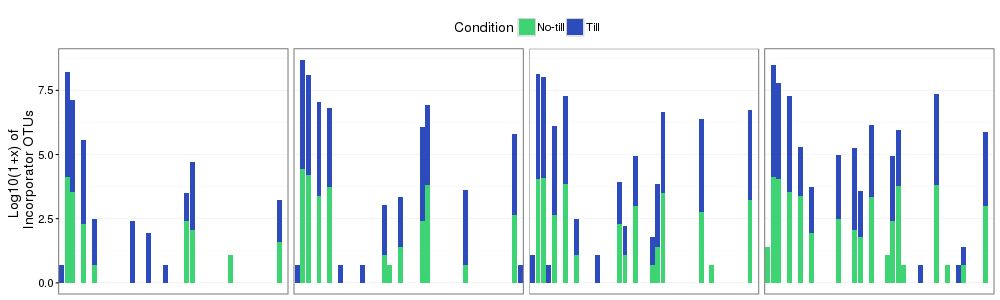

In [146]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.filt %>% group_by(Day,Group, ls) %>% summarise(resp = sum(padj <=0.10), 
                                                                         log1presp = log1p(resp))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Group, y = log1presp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') + 
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd"), labels = c('No-till', 'Till')) + theme(text = element_text(size = 14), axis.title.x = element_blank()) +
        ylab('Log10(1+x) of \n Incorporator OTUs') +  scale_x_discrete(breaks=NULL)+  
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) + theme(legend.position="top") 

p.test
p.test

In [147]:
%%R
length(df.filt$OTU)
#length(df.l2fc.f.f$OTU)

[1] 34293


In [148]:
%%R
filter(df.l2fc.f, Rank2 != 'Proteobacteria') %>% head()

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
4       13C   3         4             NTH OTU.1813      0.0000000 1.0000000
5       13C   3         4             NTH  OTU.778      0.4419146 0.3382425
6       13C   3         4             NTH OTU.5511      0.6736674 0.2322352
  padj    Rank1          Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria    Chloroflexi         __S085 __uncultured_bacterium  <NA>
3    1 Bacteria Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria Planctomycetes        __OM190 __uncultured_bacterium  <NA>
5    1 Bacteria Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1 Bacteria Pl

In [149]:
%%R -w 1500 -h 300
#Normalizing by every phyla, every day

hist.cell = df.l2fc.f.f %>% group_by(Day,Rank2) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

In [150]:
%%R
day = 14

hist.cell3 %>% filter(realresp >0.6, Day == day) %>% ungroup %>% arrange(Day, ls) %>% as.data.frame

  Day      ls            Rank2  realresp
1  14 13X-NTH    Acidobacteria 1.0000000
2  14 13X-NTH    Fibrobacteres 1.0000000
3  14 13X-NTH Gemmatimonadetes 1.0000000
4  14 13X-NTH   Proteobacteria 0.6814159
5  14 13X-NTH     Spirochaetes 1.0000000
6  14 13X-PTH      Chloroflexi 0.7666667
7  14 13X-PTH    Lentisphaerae 1.0000000
8  14 13X-PTH             TA06 1.0000000
9  14 13X-PTH             <NA> 1.0000000


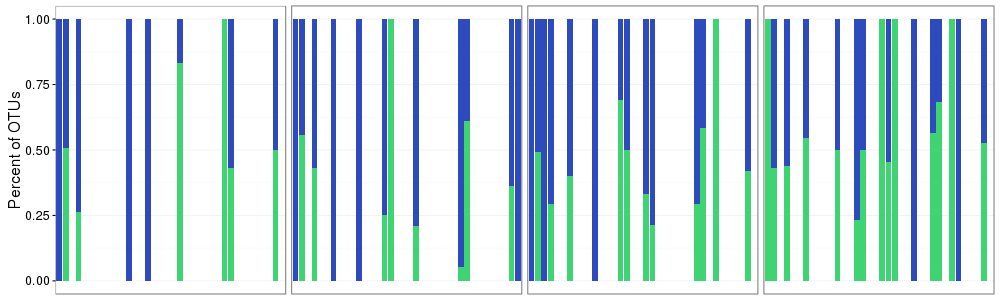

In [151]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd"), labels = c('No-till', 'Till')) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

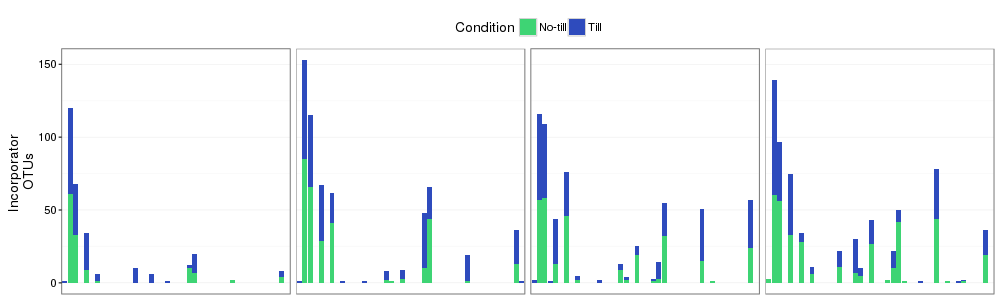

In [153]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.filt %>% group_by(Day, Group, ls) %>% summarise(resp = sum(padj <=0.10))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Group, y = resp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') + 
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd"), labels = c('No-till', 'Till')) + theme(text = element_text(size = 14), axis.title.x = element_blank()) +
        ylab('Incorporator \nOTUs') +  scale_x_discrete(breaks=NULL)+  
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) + theme(legend.position="top") 

p.test
p.test

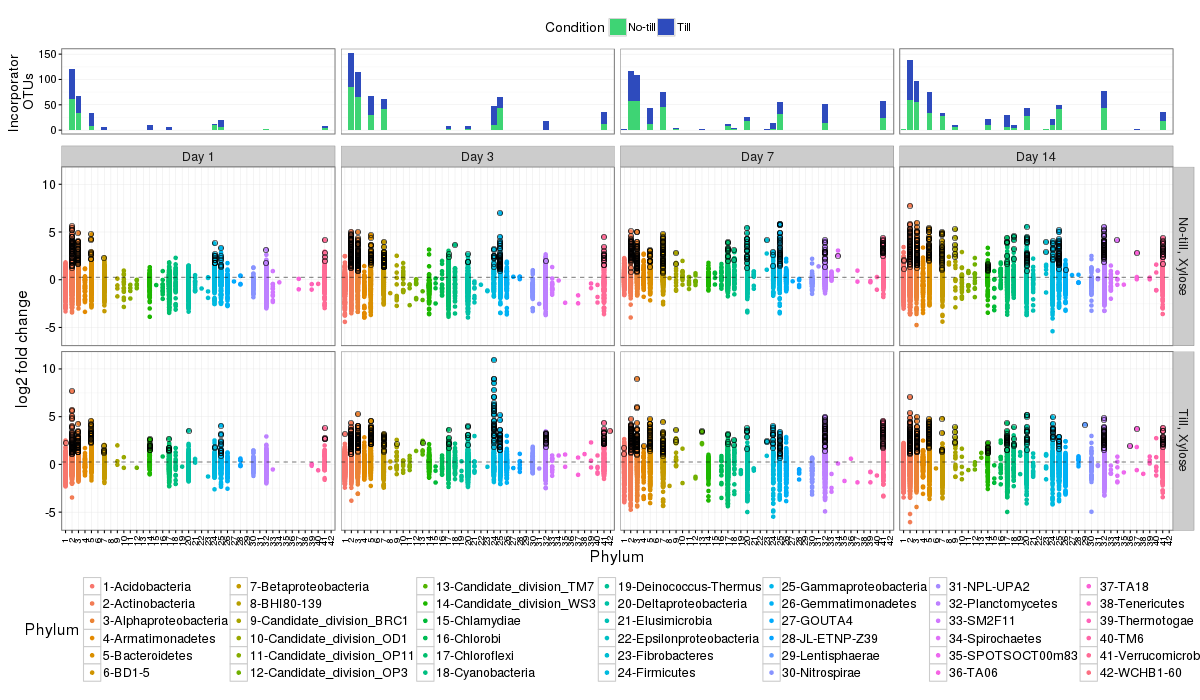

In [154]:
%%R -w 1200 -h 700
library(cowplot)

p = plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 10))
p 

In [156]:
%%R
ggsave('data/figs/Xyl_LFC.png',  width = 18, height = 14)

## l2fc plot of the richest phyla in the dataset

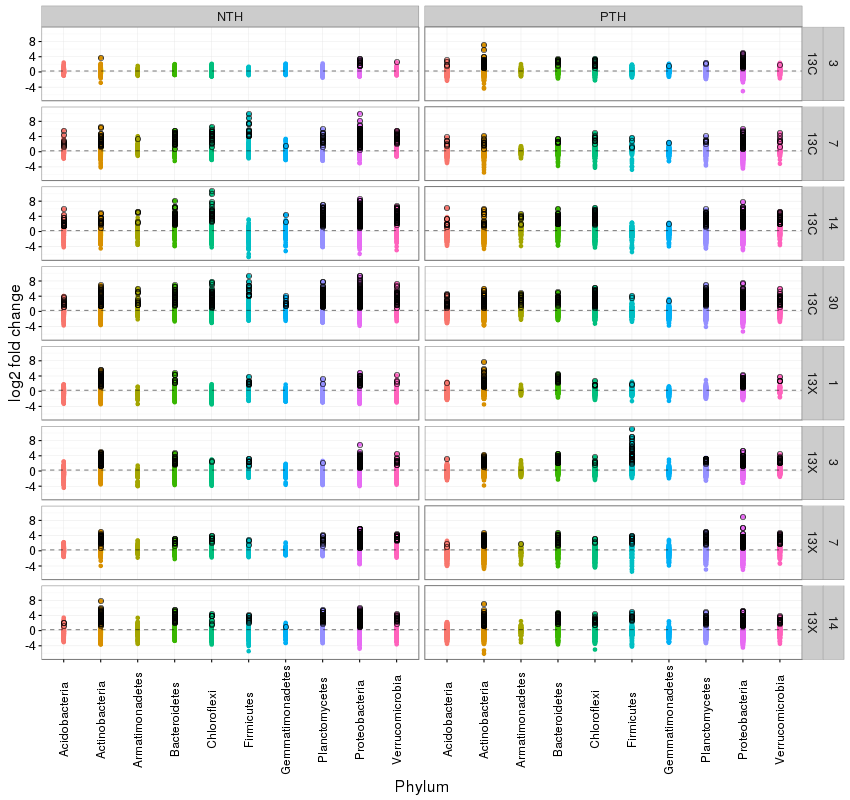

In [120]:
%%R -w 850 -h 800

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
         axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

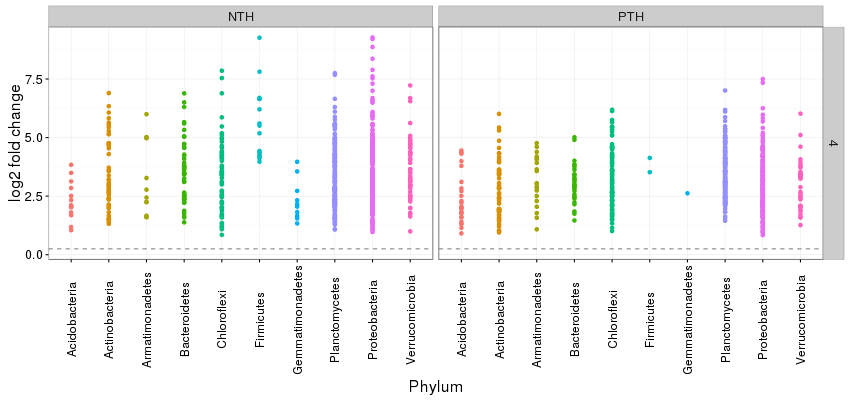

In [121]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13C', Day == '30', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

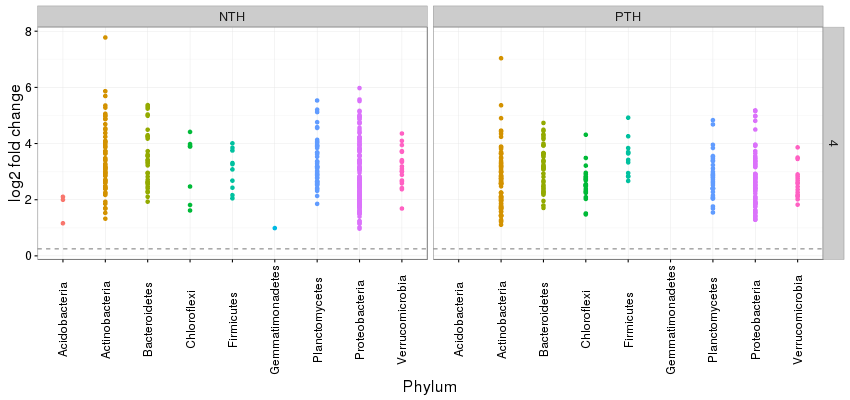

In [122]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13X', Day == '14', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

In [123]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum-rich10.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=11, height=9)

### Number of incorporators per treatment

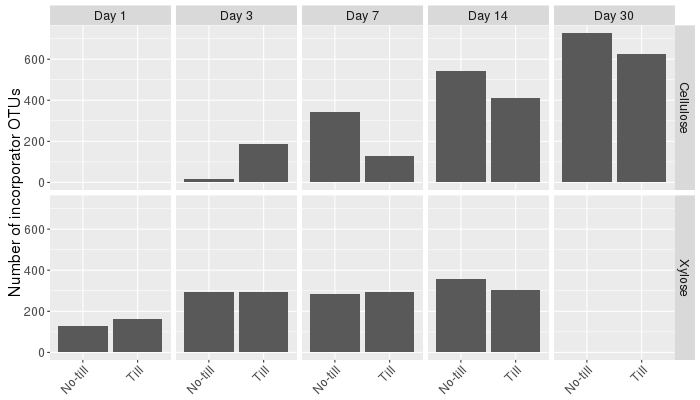

In [124]:
%%R -h 400 -w 700


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)



names = c('13X' = "Xylose",
          '13C' = "Cellulose",
          '1' = "Day 1",
          '3' = "Day 3",
          '7' = "Day 7",
          '14' = "Day 14",
          '30' = "Day 30"
                    )

p.nIncSub = ggplot(df.l2fc.f.Sig, aes(Land_Management, n_incorp)) +
    geom_bar(stat='identity') + 
    labs(y='Number of incorporator OTUs') + facet_grid(Treatment~Day, labeller = as_labeller(names))+
    theme_gray() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        ) + scale_x_discrete(labels=c("No-till", "Till"))
p.nIncSub

In [125]:
%%R
df.l2fc.f.Sig

Source: local data frame [16 x 6]
Groups: Treatment, Day [?]

   Treatment   Day Land_Management n_taxa n_incorp n_incorp_perc
      (fctr) (int)          (fctr)  (int)    (int)         (dbl)
1        13C     3             NTH   7422       17     0.2290488
2        13C     3             PTH   3551      185     5.2098001
3        13C     7             NTH   5758      345     5.9916638
4        13C     7             PTH   3810      128     3.3595801
5        13C    14             NTH   5923      545     9.2014182
6        13C    14             PTH   5122      412     8.0437329
7        13C    30             NTH   7443      728     9.7810023
8        13C    30             PTH   7504      623     8.3022388
9        13X     1             NTH   4101      127     3.0968057
10       13X     1             PTH   2747      161     5.8609392
11       13X     3             NTH   4235      295     6.9657615
12       13X     3             PTH   5204      293     5.6302844
13       13X     7          

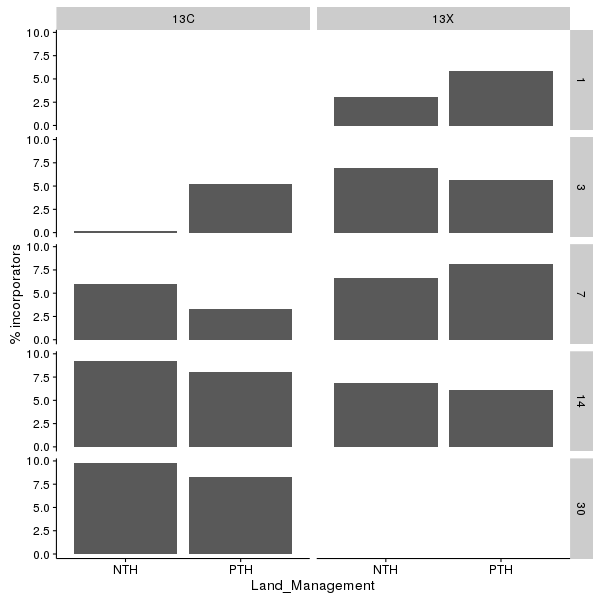

In [126]:
%%R -h 600 -w 600


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)

p.nIncSub = ggplot(df.l2fc.f.Sig, aes(Land_Management, n_incorp_perc)) +
    geom_bar(stat='identity') + 
    labs(y='% incorporators') + facet_grid(Day~Treatment)
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        )
p.nIncSub

#### Notes

* The figure shows the number of incorporators normalized by the number of taxa in observed in any gradient fraction associated with that substrate.

### Number of incorporators per treatment/time

In [127]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(n = sum(padj < padj_cutoff)) %>%
    ungroup()

p.nInc = ggplot(df.l2fc.f.sig, aes(Day, n, color=Land_Management, group=Land_Management, shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Number of incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) + facet_wrap(~Treatment)
p.nInc

RRuntimeError: Error: A continuous variable can not be mapped to shape


### Number of incorporators normalized by number of taxa in each sample

In [ ]:
%%R
df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(ntaxa = n())

In [ ]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Replicate, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup()

p.nInc.norm = ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, group=Land_Management,
                                        shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        ) + facet_wrap(~Treatment)
p.nInc.norm

In [ ]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm, width=10, height=3.5)

In [ ]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm-labile.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm.labile, width=10, height=3.5)

In [ ]:
%%R -w 1000 -h 1300

padj_cutoff = 0.05
n_incorp_norm_perc_cutoff = 0.05

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Rank2, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    filter(n_incorp_norm_perc >= n_incorp_norm_perc_cutoff)

ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, shape = Treatment)) +
    geom_jitter(size = 2, width = 0.25) +
    geom_line(alpha=0.5) +
    facet_grid(Rank2 ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

In [ ]:
%%R -w 1200 -h 900

df.l2fc.f.sig.e = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.e$Day = reorder(df.l2fc.f.sig.e$Day, df.l2fc.f.sig.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.e, aes(Day, n_incorp_norm_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_x', space='free') +
    labs(y='Incorporator OTUs (% of OTUs in the pre-fractionation community)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) 

## Plotting normalized by total taxa in phylulm

In [ ]:
%%R
n_OTUs_phylum = df.l2fc.f %>% 
    group_by(Treatment, Land_Management, Day, Rank2) %>%
    summarize(n_OTUs = n())

n_OTUs_phylum

In [ ]:
%%R

df.l2fc.f.sig.j = inner_join(df.l2fc.f.sig, n_OTUs_phylum, c('Day' = 'Day',
                                                              'Treatment' = 'Treatment',
                                                              'Land_Management' = 'Land_Management',
                                                              'Rank2' = 'Rank2')) %>%
                    mutate(n_incorp_normByPhylum_perc = n_incorp / n_OTUs * 100)
                             
df.l2fc.f.sig.j %>% head(n=3) %>% as.data.frame 

In [ ]:
%%R -w 800 -h 850

df.l2fc.f.sig.j.e = df.l2fc.f.sig.j %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.j.e$Day = reorder(df.l2fc.f.sig.j.e$Day, df.l2fc.f.sig.j.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.j.e, aes(Day, n_incorp_normByPhylum_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_y', space='fixed') +
    labs(y='Incorporator OTUs (% of OTUs in the phylum)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )